In [1]:
# Install Java (required for Spark)
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Download and install Apache Spark 3.4.1
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz

# Install PySpark and Findspark
!pip install -q pyspark findspark

In [7]:
# Set up environment variables
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

# Initialize Findspark
findspark.init()

# Import PySpark Libraries
from pyspark.sql import SparkSession

# ✅ Step 2: Create Spark Session
spark = SparkSession.builder.appName("StockMarketAnalysis").getOrCreate()

# Print Spark version to verify installation
print("Apache Spark Version:", spark.version)

# Statement confirming Spark installation
print("\nApache Spark is successfully installed and ready to use!")


Apache Spark Version: 3.4.1

Apache Spark is successfully installed and ready to use!


In [8]:
# Define file path (modify if needed)
data_path = "/content/"

# Load CSV files into Spark DataFrames
fundamentals_df = spark.read.csv(data_path + "fundamentals.csv", header=True, inferSchema=True)
price_split_df = spark.read.csv(data_path + "prices-split-adjusted.csv", header=True, inferSchema=True)
prices_df = spark.read.csv(data_path + "prices.csv", header=True, inferSchema=True)
securities_df = spark.read.csv(data_path + "securities.csv", header=True, inferSchema=True)

In [9]:
fundamentals_df.show(5)

print("Sample data from Price Split Adjusted:")
price_split_df.show(5)

print("Sample data from Prices:")
prices_df.show(5)

print("Sample data from Securities:")
securities_df.show(5)


+---+-------------+-------------+----------------+-------------------+--------------------------+-------------+--------------------+---------------+----------+-------------------------+----------------------+-------------+---------------+-------------+----------------------+--------------------------+------------+--------------------------------+-------------------+-----------------------+----------------------------------------------+------------+--------+------------+------------+----------+-----------------+----------------+----------+-----------+-----------+--------------+---------------------+-----------------+------------+--------------+-------------+-----------------------+------------------------+------------------------+----------+----------------------+--------------------------------------------+---------------------------+---------------+-------------------+----------------+----------------+------------+--------------------+-------------------------+------------+-----------

In [11]:
# # Apply column name cleaning to all dataframes
# for df in [fundamentals_df, prices_df, price_split_df, securities_df]:
#     for col_name in df.columns:
#         clean_col_name = col_name.replace(" ", "_").replace(",", "").replace(".", "")
#         df = df.withColumnRenamed(col_name, clean_col_name)

# # Drop rows with missing values from all dataframes
# prices_df = prices_df.dropna()
# fundamentals_df = fundamentals_df.dropna()
# price_split_df = price_split_df.dropna()
# securities_df = securities_df.dropna()

# # Verify the schema after modifications
# fundamentals_df.printSchema()
# prices_df.printSchema()
# price_split_df.printSchema()
# securities_df.printSchema()

def clean_column_names(df):
    for col_name in df.columns:
        clean_col_name = col_name.replace(" ", "_").replace(",", "").replace(".", "")
        df = df.withColumnRenamed(col_name, clean_col_name)
    return df

# Apply the function to all DataFrames
fundamentals_df = clean_column_names(fundamentals_df)
prices_df = clean_column_names(prices_df)
price_split_df = clean_column_names(price_split_df)
securities_df = clean_column_names(securities_df)

# Now drop missing values
fundamentals_df = fundamentals_df.dropna()
prices_df = prices_df.dropna()
price_split_df = price_split_df.dropna()
securities_df = securities_df.dropna()

# Verify schemas
fundamentals_df.printSchema()
prices_df.printSchema()
price_split_df.printSchema()
securities_df.printSchema()


root
 |-- _c0: integer (nullable = true)
 |-- Ticker_Symbol: string (nullable = true)
 |-- Period_Ending: date (nullable = true)
 |-- Accounts_Payable: double (nullable = true)
 |-- Accounts_Receivable: double (nullable = true)
 |-- Add'l_income/expense_items: double (nullable = true)
 |-- After_Tax_ROE: double (nullable = true)
 |-- Capital_Expenditures: double (nullable = true)
 |-- Capital_Surplus: double (nullable = true)
 |-- Cash_Ratio: double (nullable = true)
 |-- Cash_and_Cash_Equivalents: double (nullable = true)
 |-- Changes_in_Inventories: double (nullable = true)
 |-- Common_Stocks: double (nullable = true)
 |-- Cost_of_Revenue: double (nullable = true)
 |-- Current_Ratio: double (nullable = true)
 |-- Deferred_Asset_Charges: double (nullable = true)
 |-- Deferred_Liability_Charges: double (nullable = true)
 |-- Depreciation: double (nullable = true)
 |-- Earnings_Before_Interest_and_Tax: double (nullable = true)
 |-- Earnings_Before_Tax: double (nullable = true)
 |-- Effe

In [12]:
from pyspark.sql.functions import avg, max, min

# Calculate average, max, and min closing prices for each stock symbol using Spark
average_prices = prices_df.groupBy("symbol").agg(
    avg("close").alias("avg_price"),
    max("close").alias("max_price"),
    min("close").alias("min_price")
)

average_prices.show()


+------+------------------+----------+----------+
|symbol|         avg_price| max_price| min_price|
+------+------------------+----------+----------+
|  ALXN|115.54262206696932|207.839996| 44.610001|
|   GIS| 49.72901248581155| 75.139999|     33.57|
|     K|60.812451743473325| 86.980003| 46.509998|
|   LEN|  33.6965210079455|     55.59|     12.71|
|  SPGI| 67.37934733995459|127.559998|     27.02|
|   AVY|46.330249744608444| 78.839996| 23.969999|
|   AIV|30.457446065266804|     47.59|     15.21|
|   MMM|120.14518169636787|181.419998|     70.93|
|   PKI|36.454358666855846| 56.919998|     17.49|
|   PPG|125.27111243586839|237.699997|     57.68|
|    RF| 8.282837684449492|     14.64|      3.02|
|   AXP| 64.23203746481279| 95.839996| 36.790001|
|    CI|  79.3213167111237|169.770004|     29.77|
|   IRM|30.955034330873993|     41.25| 20.249998|
|   WEC| 46.11257092451757|     65.82| 27.940001|
|   PFG|38.173030638479005| 60.860001| 21.219999|
|    PM| 79.79687845913736|103.629997| 43.169998|


In [14]:
# # Find stock with the highest closing price
# highest_stock = prices_df.orderBy(col("close").desc()).limit(1)
# highest_stock.show()

# # Find stock with the lowest closing price
# lowest_stock = prices_df.orderBy(col("close").asc()).limit(1)
# lowest_stock.show()

from pyspark.sql.functions import col

# Find stock with the highest closing price
highest_stock = prices_df.orderBy(col("close").desc()).limit(1)
highest_stock.show()

# Find stock with the lowest closing price
lowest_stock = prices_df.orderBy(col("close").asc()).limit(1)
lowest_stock.show()


+-------------------+------+------+-----------+------+-----------+---------+
|               date|symbol|  open|      close|   low|       high|   volume|
+-------------------+------+------+-----------+------+-----------+---------+
|2016-11-08 00:00:00|  PCLN|1540.0|1578.130005|1540.0|1589.209961|1559000.0|
+-------------------+------+------+-----------+------+-----------+---------+

+-------------------+------+----+-----+----+----+--------+
|               date|symbol|open|close| low|high|  volume|
+-------------------+------+----+-----+----+----+--------+
|2010-10-11 00:00:00|  LVLT| 0.9| 0.86|0.85|0.92|9.3277E7|
+-------------------+------+----+-----+----+----+--------+



In [16]:
# # Rename 'Ticker symbol' column to 'symbol' in the securities_df
# securities_df = securities_df.withColumnRenamed("Ticker symbol", "symbol")

# # Now join prices_df with securities_df on 'symbol' to get more details about each stock
# merged_df = prices_df.join(securities_df, on="symbol", how="inner")

# # Show the first few rows of the merged data
# merged_df.show(5)

from pyspark.sql.functions import col

# Clean column names again if needed
securities_df = clean_column_names(securities_df)

# Rename Ticker_symbol to symbol
securities_df = securities_df.withColumnRenamed("Ticker_symbol", "symbol")

# Confirm it's renamed
securities_df.printSchema()

# Join on 'symbol'
merged_df = prices_df.join(securities_df, on="symbol", how="inner")

# Show merged result
merged_df.show(5)


root
 |-- symbol: string (nullable = true)
 |-- Security: string (nullable = true)
 |-- SEC_filings: string (nullable = true)
 |-- GICS_Sector: string (nullable = true)
 |-- GICS_Sub_Industry: string (nullable = true)
 |-- Address_of_Headquarters: string (nullable = true)
 |-- Date_first_added: date (nullable = true)
 |-- CIK: integer (nullable = true)

+------+-------------------+----------+----------+----------+----------+---------+--------------------+-----------+-----------+-----------------+-----------------------+----------------+-------+
|symbol|               date|      open|     close|       low|      high|   volume|            Security|SEC_filings|GICS_Sector|GICS_Sub_Industry|Address_of_Headquarters|Date_first_added|    CIK|
+------+-------------------+----------+----------+----------+----------+---------+--------------------+-----------+-----------+-----------------+-----------------------+----------------+-------+
|  WLTW|2016-01-05 00:00:00|    123.43|125.839996|122.30999

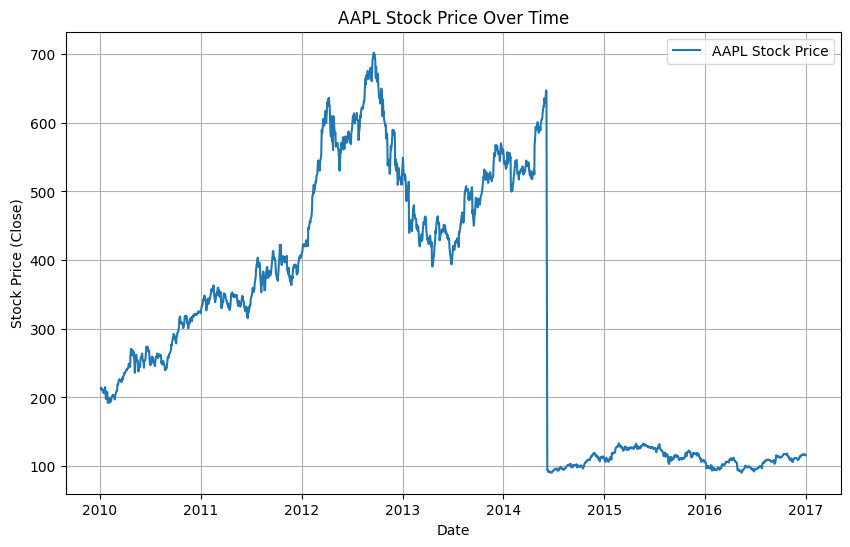

In [20]:
# # Filter for a specific stock (change 'symbol_name' to a valid symbol from the dataset)
# symbol_name = "AAPL"  # Example: Replace with an actual symbol from your dataset

# # Filter merged dataset for the chosen stock
# stock_data = merged_df.filter(merged_df['symbol'] == symbol_name).select("date", "close").toPandas()

# # Check if data exists for the symbol
# if stock_data.empty:
#     print(f"No data found for symbol: {symbol_name}")
# else:
#     # Convert the 'date' column to datetime format for proper plotting
#     stock_data['date'] = pd.to_datetime(stock_data['date'])

#     # Plot stock prices over time
#     import matplotlib.pyplot as plt

#     plt.figure(figsize=(10, 6))
#     plt.plot(stock_data['date'], stock_data['close'], label=f"{symbol_name} Stock Price")
#     plt.title(f"{symbol_name} Stock Price Over Time")
#     plt.xlabel('Date')
#     plt.ylabel('Stock Price (Close)')
#     plt.grid(True)
#     plt.legend()
#     plt.show()

from pyspark.sql.functions import col

# Cast the 'date' column to string before calling toPandas()
stock_data = merged_df \
    .filter(col('symbol') == symbol_name) \
    .withColumn("date", col("date").cast("string")) \
    .select("date", "close") \
    .toPandas()

# Check if data exists
if stock_data.empty:
    print(f"No data found for symbol: {symbol_name}")
else:
    # Convert 'date' to datetime in Pandas
    stock_data['date'] = pd.to_datetime(stock_data['date'], errors='coerce')

    # Plotting
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(stock_data['date'], stock_data['close'], label=f"{symbol_name} Stock Price")
    plt.title(f"{symbol_name} Stock Price Over Time")
    plt.xlabel('Date')
    plt.ylabel('Stock Price (Close)')
    plt.grid(True)
    plt.legend()
    plt.show()


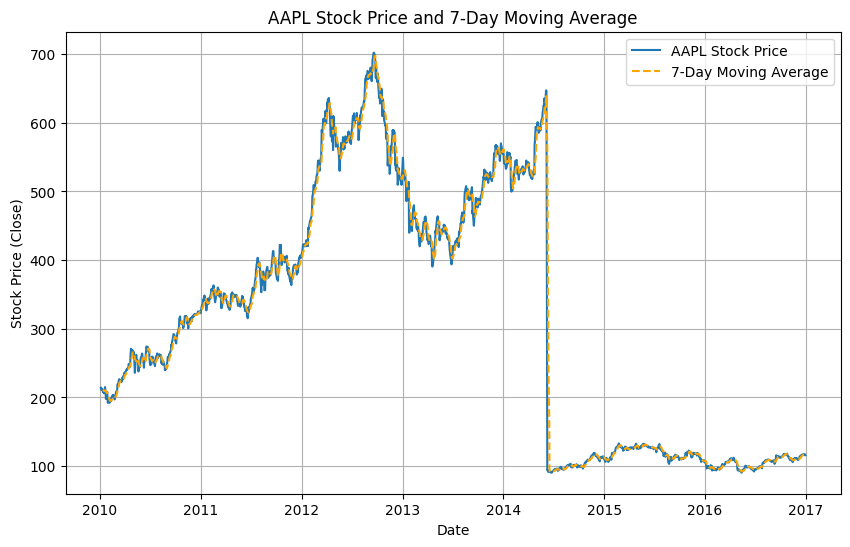

In [21]:
# Calculate 7-day moving average for the stock
stock_data['7_day_MA'] = stock_data['close'].rolling(window=7).mean()

# Plot stock price and moving average
plt.figure(figsize=(10, 6))
plt.plot(stock_data['date'], stock_data['close'], label=f"{symbol_name} Stock Price")
plt.plot(stock_data['date'], stock_data['7_day_MA'], label="7-Day Moving Average", linestyle='--', color='orange')
plt.title(f"{symbol_name} Stock Price and 7-Day Moving Average")
plt.xlabel('Date')
plt.ylabel('Stock Price (Close)')
plt.grid(True)
plt.legend()
plt.show()


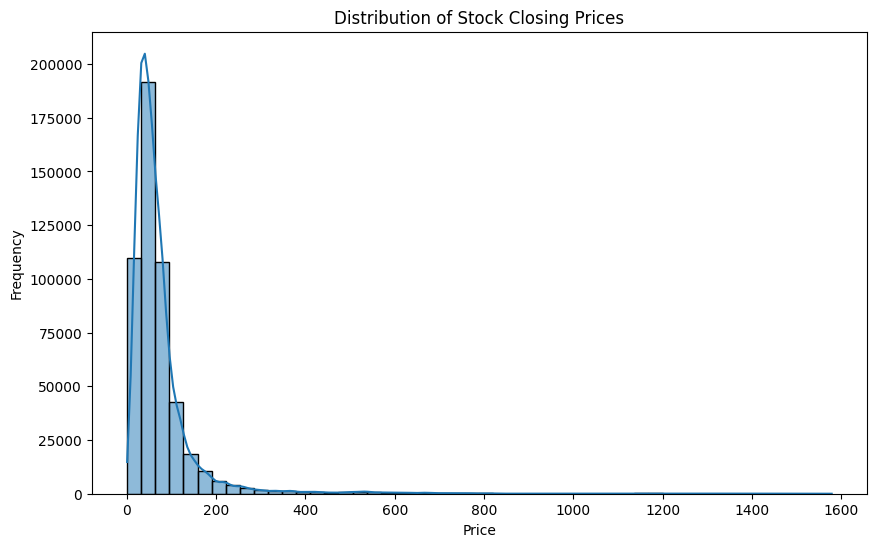

In [22]:
# Convert Spark DataFrame to Pandas for visualization
merged_pd_df = merged_df.select("close").toPandas()

# Plot distribution of closing prices
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(merged_pd_df['close'], bins=50, kde=True)
plt.title('Distribution of Stock Closing Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


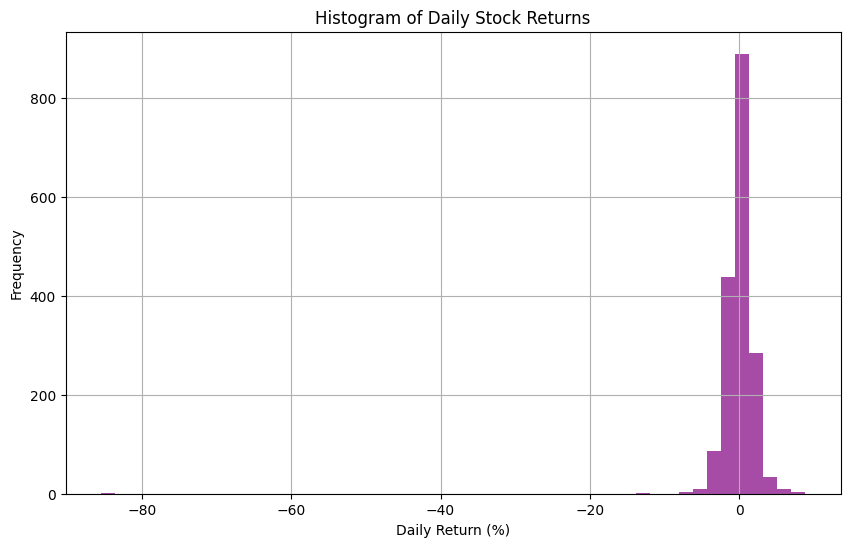

In [23]:
  # Calculate daily returns (percentage change)
  stock_data['daily_return'] = stock_data['close'].pct_change() * 100

  # Plot histogram of daily returns
  plt.figure(figsize=(10, 6))
  plt.hist(stock_data['daily_return'].dropna(), bins=50, color='purple', alpha=0.7)
  plt.title('Histogram of Daily Stock Returns')
  plt.xlabel('Daily Return (%)')
  plt.ylabel('Frequency')
  plt.grid(True)
  plt.show()


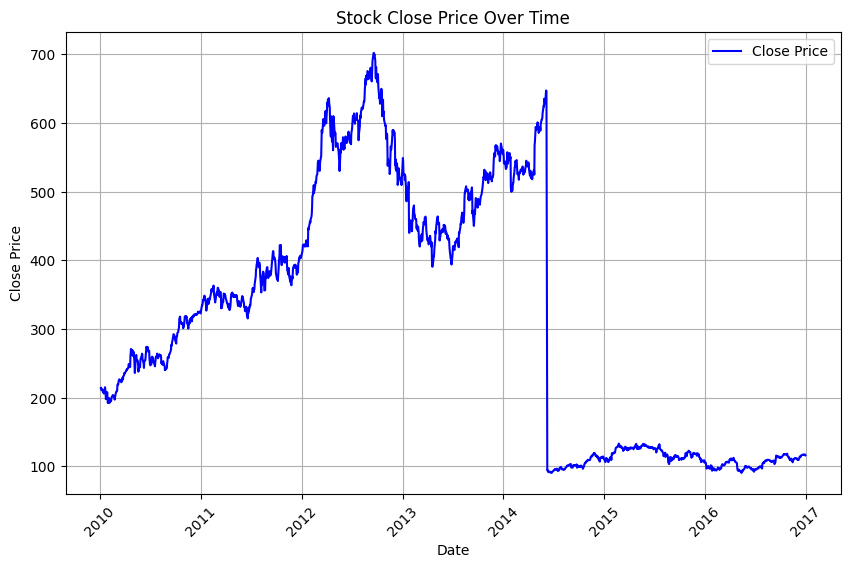

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(stock_data['date'], stock_data['close'], label="Close Price", color='blue')
plt.title('Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels if necessary
plt.show()


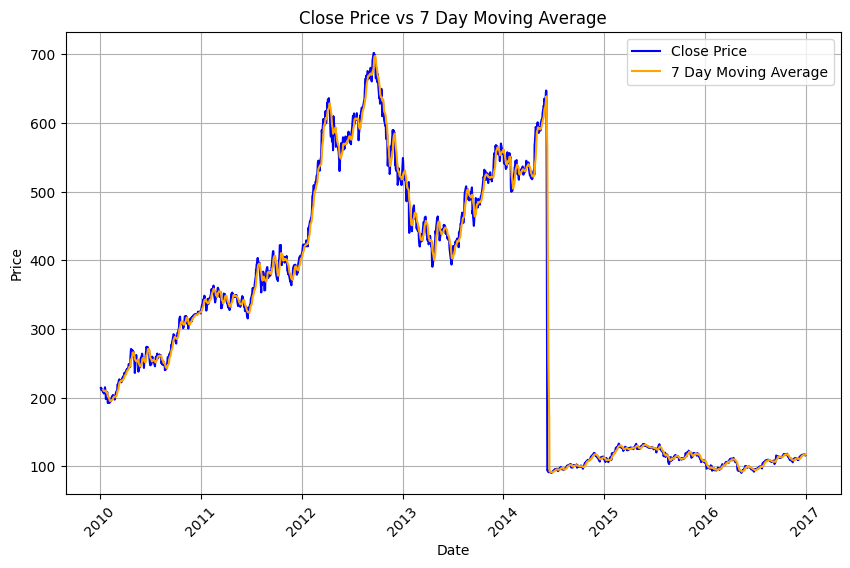

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(stock_data['date'], stock_data['close'], label="Close Price", color='blue')
plt.plot(stock_data['date'], stock_data['7_day_MA'], label="7 Day Moving Average", color='orange')
plt.title('Close Price vs 7 Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()


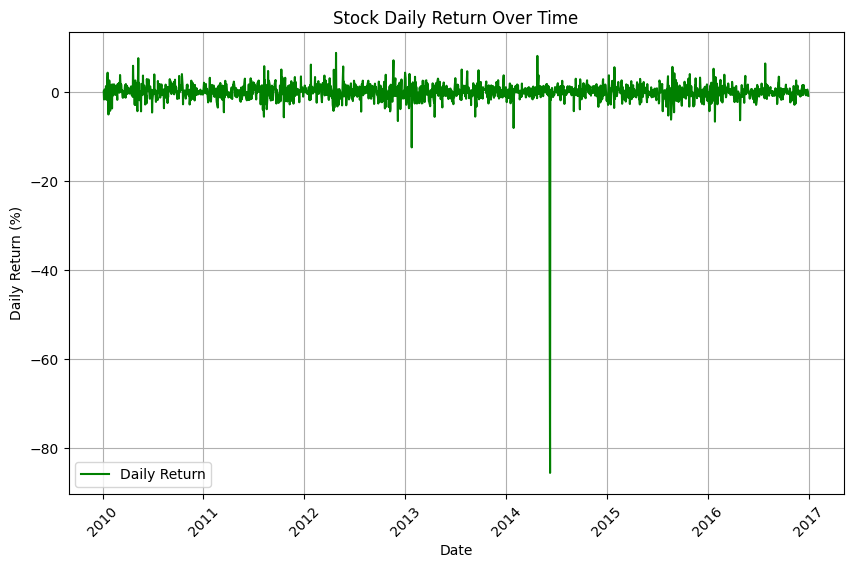

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(stock_data['date'], stock_data['daily_return'], label="Daily Return", color='green')
plt.title('Stock Daily Return Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()


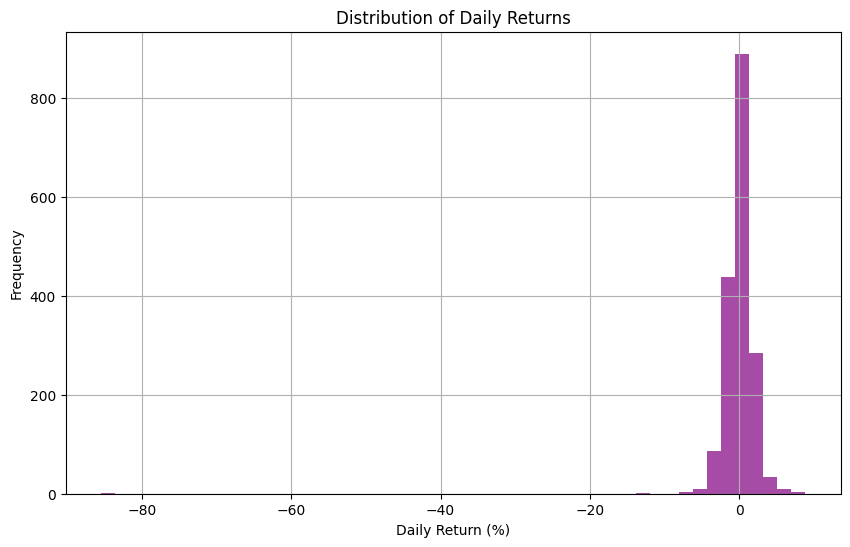

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(stock_data['daily_return'], bins=50, color='purple', alpha=0.7)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


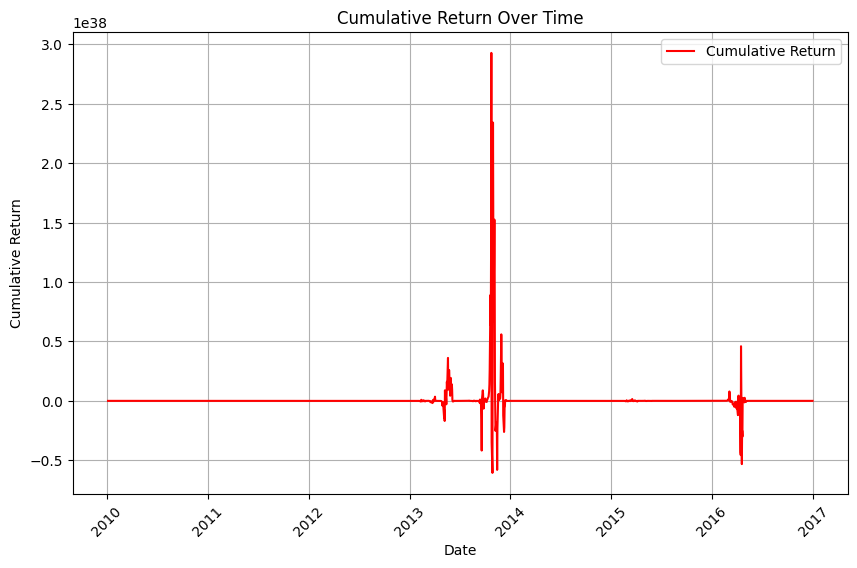

In [28]:
stock_data['cumulative_return'] = (1 + stock_data['daily_return']).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(stock_data['date'], stock_data['cumulative_return'], label="Cumulative Return", color='red')
plt.title('Cumulative Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()


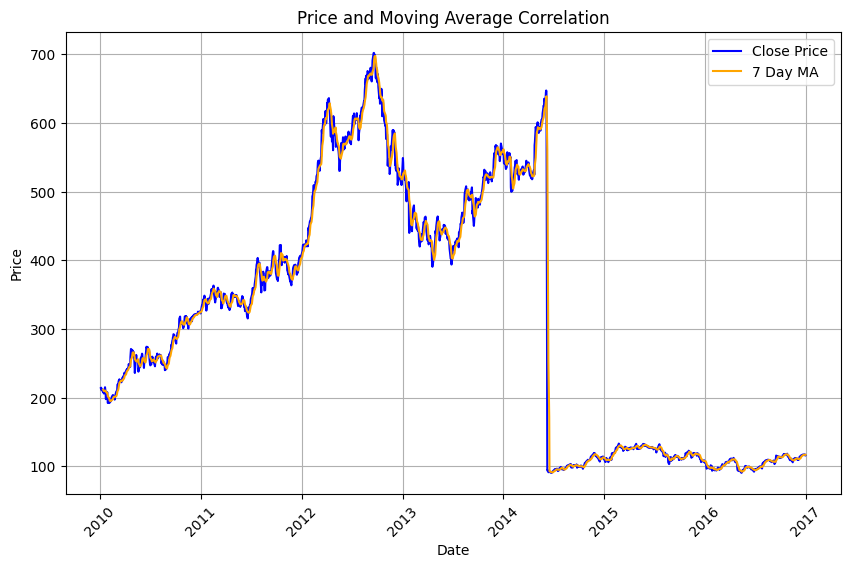

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(stock_data['date'], stock_data['close'], label="Close Price", color='blue')
plt.plot(stock_data['date'], stock_data['7_day_MA'], label="7 Day MA", color='orange')
plt.title('Price and Moving Average Correlation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [30]:
!pip install gradio pandas matplotlib pyspark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 120.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.1 MB/s eta 0:00:00


In [31]:
import gradio as gr
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

def plot_stock(symbol_name):
    # Cast 'date' to string and convert to Pandas DataFrame
    try:
        stock_data = merged_df \
            .filter(col('symbol') == symbol_name) \
            .withColumn("date", col("date").cast("string")) \
            .select("date", "close") \
            .toPandas()
    except Exception as e:
        return f"Error loading data: {str(e)}"

    if stock_data.empty:
        return f"No data found for symbol: {symbol_name}"

    # Convert date column to datetime
    stock_data['date'] = pd.to_datetime(stock_data['date'], errors="coerce")

    # Create plot
    plt.figure(figsize=(10, 5))
    plt.plot(stock_data['date'], stock_data['close'], label=f"{symbol_name} Stock Price", color='navy')
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.title(f"{symbol_name} Stock Price Over Time")
    plt.grid(True)
    plt.legend()

    # Save plot to a file
    plt.tight_layout()
    return plt

# Create Gradio interface
interface = gr.Interface(
    fn=plot_stock,
    inputs=gr.Textbox(label="Enter Stock Symbol (e.g., AAPL)"),
    outputs=gr.Plot(label="Stock Price Chart"),
    title="Stock Price Visualizer",
    description="Enter a stock symbol to see its closing price over time."
)

# Launch interface
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://796150757180823777.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
